In [1]:
!pip install brian2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.6 MB/s eta 0:00:00


In [2]:
from brian2 import *
import matplotlib.pyplot as plt

In [3]:
seed(0)
prefs.codegen.target = "numpy"

In [4]:
# parameters
simulation_duration = 6 * second

# 뉴런
taum = 10*ms
Ee = 0*mV
vt = -54*mV
vr = -60*mV
El = -74*mV
taue = 5*ms

# STDP
taupre  = 20*ms
taupost = taupre
gmax = .01
dApre = .01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre  *= gmax

# 도파민 신호
tauc = 1000*ms          # eligibility trace c(t) decay
taud = 200*ms           # dopamine trace d(t) decay
taus = 1*ms             # 가중치 적용 속도
epsilon_dopa = 5e-3     # 도파민 스파이크 1회당 d 증가량

In [5]:
# 자극 정의
# 2개의 입력 뉴런이 특정 시점에 spike
input_indices = array([0, 1, 0, 1, 1, 0,
                       0, 1, 0, 1, 1, 0])
input_times = array([ 500,  550, 1000, 1010, 1500, 1510,
                     3500, 3550, 4000, 4010, 4500, 4510])*ms
spike_input = SpikeGeneratorGroup(2, input_indices, input_times)

In [6]:
# post뉴런 2개
neurons = NeuronGroup(
    2,
    '''dv/dt = (ge * (Ee - v) + El - v) / taum : volt
       dge/dt = -ge / taue : 1''',
    threshold='v>vt',
    reset='v = vr',
    method='euler'
)
neurons.v = vr
neurons_mon = SpikeMonitor(neurons)


In [7]:
# input -> 뉴런 직접 연결 (자극 전달)
stim = Synapses(spike_input, neurons, model='s: volt', on_pre='v += s')
stim.connect(i=[0,1], j=[0,1])     # 0->0 / 1->1
stim.s = 100.*mV

In [8]:
# STDP 시냅스
syn = Synapses(
    neurons, neurons,
    model='''
        mode : 1
        dc/dt = -c / tauc : 1 (clock-driven)     # eligibility trace
        dd/dt = -d / taud : 1 (clock-driven)     # dopamine trace
        ds/dt = mode * c * d / taus : 1 (clock-driven)  # 실제 가중치 적용(보상 있을 때)
        dApre/dt  = -Apre  / taupre  : 1 (event-driven)
        dApost/dt = -Apost / taupost : 1 (event-driven)
    ''',
    on_pre='''
        ge += s
        Apre += dApre
        c = clip(c + mode * Apost, -gmax, gmax)
        s = clip(s + (1 - mode) * Apost, -gmax, gmax)
    ''',
    on_post='''
        Apost += dApost
        c = clip(c + mode * Apre, -gmax, gmax)
        s = clip(s + (1 - mode) * Apre, -gmax, gmax)
    ''',
    method='euler'
)
syn.connect(i=0, j=1)     # pre: neuron0 -> post: neuron1
syn.mode = 0              # classical로 시작
syn.s = 1e-10             # w 초기값
syn.c = 1e-10             # eligibility 초기값
syn.d = 0                 # 도파민 초기값

syn_mon = StateMonitor(syn, ['s','c','d'], record=[0])


In [9]:
# 도파민 input
dopamine_indices = array([0, 0, 0])
dopamine_times = array([3520, 4020, 4520])*ms  # 보상 타이밍
dopamine = SpikeGeneratorGroup(1, array([0,0,0]), dopamine_times)
dopamine_mon = SpikeMonitor(dopamine)

# 도파민 spike가 syn.dd_post 증가 시ㅣ킴 (보상 신호 전달)
reward = Synapses(dopamine, syn, on_pre='d_post += epsilon_dopa', method='exact')
reward.connect()

In [10]:
# 시뮬
# 앞에꺼 반 classical STDP
syn.mode = 0
run(simulation_duration/2, report='text')

Starting simulation at t=0. s for a duration of 3. s
3. s (100%) simulated in 5s


In [11]:
# 뒤에꺼 반 Dopamine modulated STDP
syn.mode = 1
run(simulation_duration/2, report='text')

Starting simulation at t=3. s for a duration of 3. s
3. s (100%) simulated in 4s


In [12]:
dop_i, dop_t = dopamine_mon.it
neu_i, neu_t = neurons_mon.it

plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

WARNING    /tmp/ipython-input-3699634166.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right', frameon=False)
 [py.warnings]
  plt.legend(loc='upper right', frameon=False)



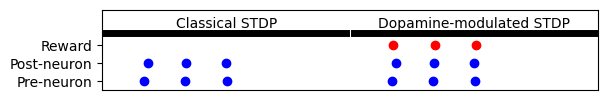

In [22]:
plt.subplot(4,1,1)
plt.plot([0.05, (simulation_duration/second)/2 - 0.05], [2.7, 2.7], lw=5, color='k')
plt.text((simulation_duration/second)/4, 3, 'Classical STDP', ha='center', fontsize=10)
plt.plot([(simulation_duration/second)/2 + 0.05, simulation_duration/second - 0.05], [2.7, 2.7], lw=5, color='k')
plt.text(3*(simulation_duration/second)/4, 3, 'Dopamine-modulated STDP', ha='center')
plt.plot(neu_t, neu_i, 'ob')
plt.plot(dop_t, dop_i + 2, 'or')
plt.xlim([0, simulation_duration/second])
plt.ylim([-0.5, 4])
plt.yticks([0,1,2], ['Pre-neuron','Post-neuron','Reward'])
plt.xticks([])
plt.legend(loc='upper right', frameon=False)

([], [])

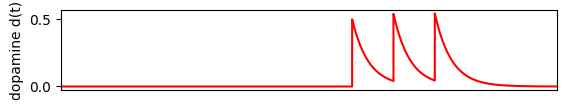

In [23]:
plt.subplot(4,1,2)
plt.plot(syn_mon.t/second, syn_mon.d.T/gmax, 'r-')
plt.ylabel('dopamine d(t)')
plt.xlim([0, simulation_duration/second])
plt.xticks([])

도파민 spike 들어올 때마다 d(t) 순간적으로 증가

이후 시간상수 td=200ms 에 따라 천천히 감소

도파민은 순간 신호지만 효과가 수백 ms 동안 유지됨.

-> 외부 보상 신호가 언제 들어왔는지, 일정 시간 동안 영향력을 갖는다는 것을 모델링



---



([], [])

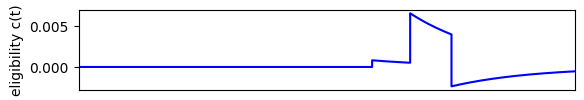

In [24]:
plt.subplot(4,1,3)
plt.plot(syn_mon.t/second, syn_mon.c.T/gmax, 'b-')
plt.ylabel('eligibility c(t)')
plt.xlim([0, simulation_duration/second])
plt.xticks([])

pre-post 스파이크 pair 발생 시 마다 c(t) 살짝 증가

tc = 1000ms 로 느리게 사라지니까 스파이크 후에도 수초 동안 흔적 남음

단독으로는 시냅스 변화 못 만들고, 도파민이 와야 weight 업뎃 일어남

-> spike 상관의ㅣ 흔적을 일단 적립해두는 메모리 역할



---



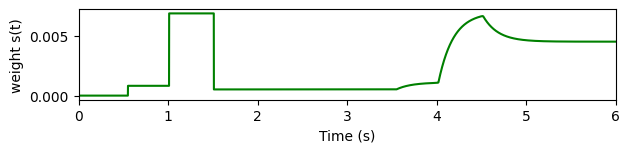

In [25]:
plt.subplot(4,1,4)
plt.plot(syn_mon.t/second, syn_mon.s.T/gmax, 'g-')
plt.ylabel('weight s(t)')
plt.xlabel('Time (s)')
plt.xlim([0, simulation_duration/second])

plt.tight_layout()
plt.show()

0-3 sec -> spike 패턴만으로 weight plot 변동 있음 (1sec LTP / 1.5sec LTD)

3-6 sec -> spike 패턴에 따라 바로 weight 로 반영되지 않고, 도파민이 들어올 때만 반영 (4초 대에 weight 상승 후 안정화)



---



classical STDP : spike 우연적 패턴에도 따라가기 때문에 불안정

Dopamine-modulated STDP : 보상 들어올 때만 반영되서 안정적 강화